# LAB 5: Text classification with Naive Bayes

Objectives:
- Train and evaluate Naive Bayes text classifiers
- Cross-validation
- Hyperparameter search

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

# Load and preprocess data

In [2]:
df = pd.read_pickle("/data/fx.pkl")

In [3]:
df

,fx,text
0,False,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...
1,False,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...
2,False,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...
3,False,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Tha...
4,False,INDONESIA SEES CPO PRICE RISING SHARPLY Indone...
...,...,...
10783,True,U.K. MONEY MARKET SHORTAGE FORECAST REVISED DO...
10784,False,KNIGHT-RIDDER INC <KRN> SETS QUARTERLY Qtly di...
10785,False,TECHNITROL INC <TNL> SETS QUARTERLY Qtly div 1...
10786,False,NATIONWIDE CELLULAR SERVICE INC <NCEL> 4TH QTR...


In [4]:
len(df.query('fx'))

717

In [5]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [6]:
def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [7]:
df["tokens"] = df["text"].progress_apply(tokenize)

  0%|          | 0/10788 [00:00<?, ?it/s]

In [8]:
df.head()

,fx,text,tokens
0,False,ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RI...,"[asian, exporters, fear, damage, from, rift, m..."
1,False,CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STO...,"[china, daily, says, vermin, eat, pct, grain, ..."
2,False,JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWA...,"[japan, to, revise, long, term, energy, demand..."
3,False,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Tha...,"[thai, trade, deficit, widens, in, first, quar..."
4,False,INDONESIA SEES CPO PRICE RISING SHARPLY Indone...,"[indonesia, sees, cpo, price, rising, sharply,..."


---

## Baseline dummy classifier

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

Set up five-fold cross-validation. We'll use the same training/test splits for all our experiments so the results will be more directly comparable.

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

In [11]:
baseline = DummyClassifier()
cross_val_score(baseline, df["tokens"], df["fx"], cv=cv)

array([0.93373494, 0.93327155, 0.93327155, 0.93370422, 0.93370422])

In [12]:
baseline_predicted = cross_val_predict(baseline, df["tokens"], df["fx"], cv=cv)
print(classification_report(df["fx"], baseline_predicted))

              precision    recall  f1-score   support

       False       0.93      1.00      0.97     10071
        True       0.00      0.00      0.00       717

    accuracy                           0.93     10788
   macro avg       0.47      0.50      0.48     10788
weighted avg       0.87      0.93      0.90     10788



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Bernoulli Naive Bayes

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline

Set up a two step pipeline: first convert tokenized text into feature vectors, then apply naive Bayes classifier

In [14]:
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

In [15]:
bnb_predicted = cross_val_predict(bnb, df["tokens"], df["fx"], cv=cv, n_jobs=-1)
print(classification_report(df["fx"], bnb_predicted))

              precision    recall  f1-score   support

       False       0.96      0.93      0.95     10071
        True       0.33      0.46      0.38       717

    accuracy                           0.90     10788
   macro avg       0.64      0.70      0.66     10788
weighted avg       0.92      0.90      0.91     10788



### Hyperparameter search

In [16]:
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

Our pipeline has (at least) three hyperparameters that need to be tuned:
- `bernoullinb__alpha`: smoothing parameter for the BernoulliNB model (default=1.0)
- `countvectorizer__min_df`: minimum document freq for a word to be included (default=1)
- `countvectorizer__max_df`: maximum fraction of documents for a word to be included (default=1.0)

In [17]:
bnb_search = RandomizedSearchCV(
    bnb,
    {"bernoullinb__alpha": loguniform(1e-10, 1.0)},
    n_iter=10,
    scoring="f1",
    n_jobs=-1,
)
bnb_search.fit(df["tokens"], df["fx"])
bnb_search.best_params_, bnb_search.best_score_

({'bernoullinb__alpha': 0.0002305379522411634}, 0.6654515688572011)

<Axes: xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

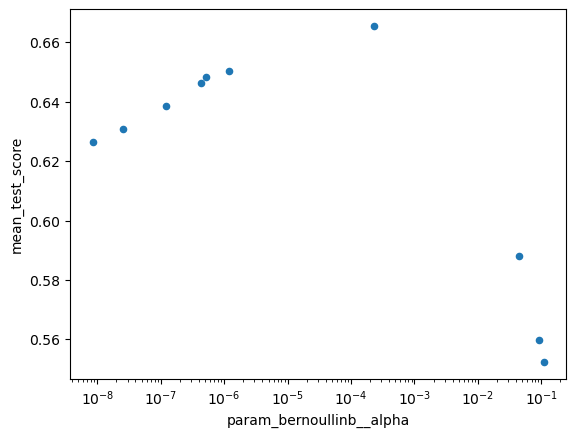

In [18]:
bnb_cv_results = pd.DataFrame(bnb_search.cv_results_)
bnb_cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

In [19]:
bnb_search = RandomizedSearchCV(
    bnb,
    {"bernoullinb__alpha": loguniform(1e-6, 1e-2)},
    n_iter=10,
    scoring="f1",
    n_jobs=-1,
)
bnb_search.fit(df["tokens"], df["fx"])
bnb_search.best_params_, bnb_search.best_score_

({'bernoullinb__alpha': 0.00010872714798485497}, 0.6674654741495344)

<Axes: xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

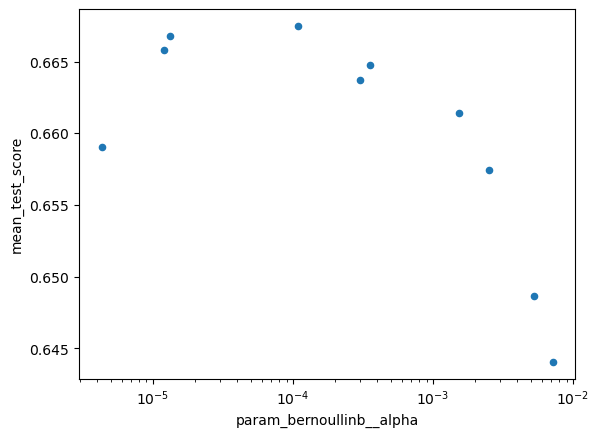

In [20]:
bnb_cv_results = pd.DataFrame(bnb_search.cv_results_)
bnb_cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

In [21]:
bnb_search = RandomizedSearchCV(
    bnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "bernoullinb__alpha": loguniform(1e-6, 1e-3),
    },
    n_iter=20,
    scoring="f1",
    n_jobs=-1,
)
bnb_search.fit(df["tokens"], df["fx"])
bnb_search.best_params_, bnb_search.best_score_

({'bernoullinb__alpha': 5.017681032502766e-06, 'countvectorizer__min_df': 2},
 0.666851492515469)

In [22]:
bnb_cv_results = pd.concat([bnb_cv_results, pd.DataFrame(bnb_search.cv_results_)])
bnb_cv_results["param_countvectorizer__min_df"] = bnb_cv_results[
    "param_countvectorizer__min_df"
].fillna(1)

<Axes: xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

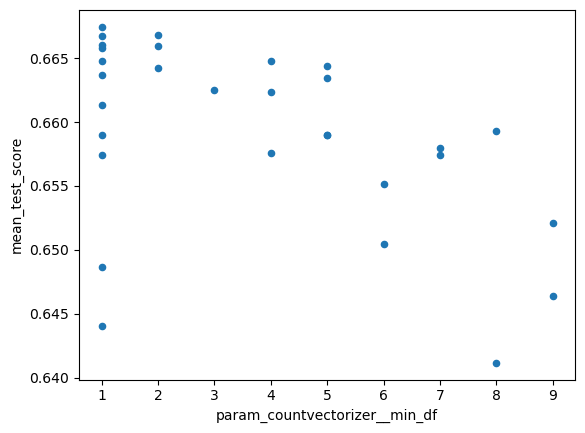

In [23]:
bnb_cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

<Axes: xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

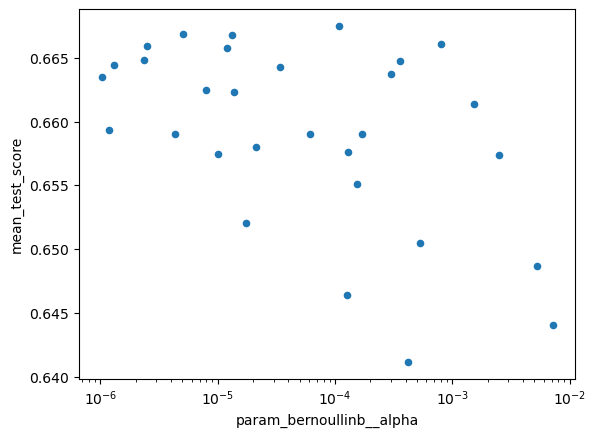

In [24]:
bnb_cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

<Axes: xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

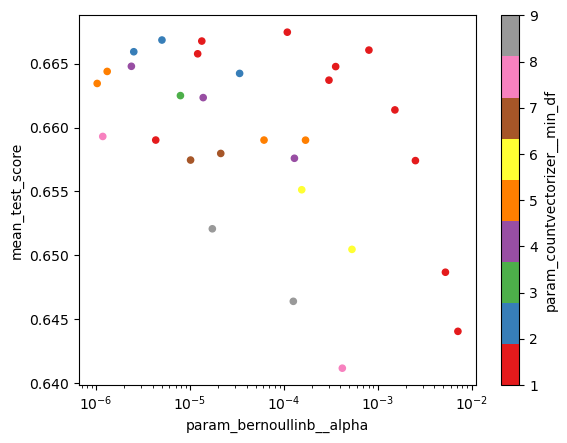

In [25]:
bnb_cv_results.plot(
    "param_bernoullinb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

In [26]:
bnb_search = RandomizedSearchCV(
    bnb,
    {
        "countvectorizer__min_df": [1, 5, 6],
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "bernoullinb__alpha": loguniform(1e-6, 1e-4),
    },
    n_iter=10,
    n_jobs=-1,
    scoring="f1",
)
bnb_search.fit(df["tokens"], df["fx"])
bnb_search.best_params_, bnb_search.best_score_

({'bernoullinb__alpha': 5.93461647704622e-05,
  'countvectorizer__max_df': 0.8420773050261684,
  'countvectorizer__min_df': 1},
 0.6675030902508607)

In [27]:
bnb_cv_results = pd.concat([bnb_cv_results, pd.DataFrame(bnb_search.cv_results_)])
bnb_cv_results["param_countvectorizer__max_df"] = bnb_cv_results[
    "param_countvectorizer__max_df"
].fillna(1.0)

<Axes: xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

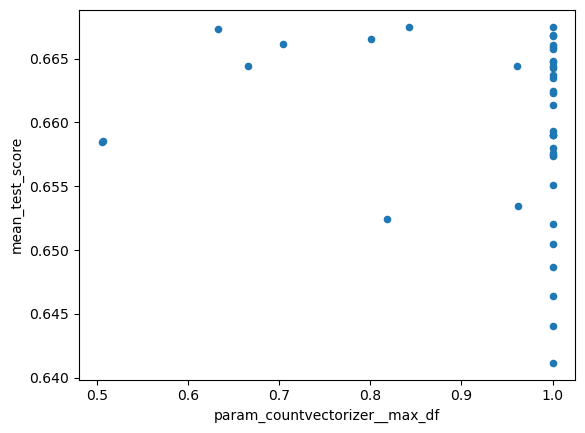

In [28]:
bnb_cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

<Axes: xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

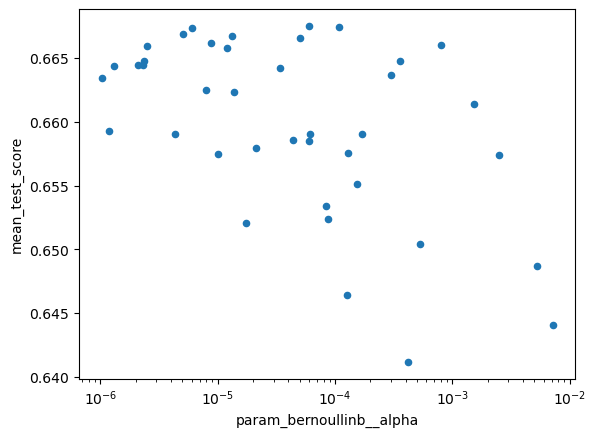

In [29]:
bnb_cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

**Observations:** min_df tuning had no difference and default has been the best. Words present in minimum of one document will be considered. Where as max_df is best at 0.8. Words present in more than 80 percent of documents were ignored. Smoothing parameter alpha has been good at 1e-4.

In [30]:
bnb.set_params(
    bernoullinb__alpha=1e-4, countvectorizer__min_df=1, countvectorizer__max_df=0.8
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2b189b58fe00>,
                                 max_df=0.8)),
                ('bernoullinb', BernoulliNB(alpha=0.0001))])

In [31]:
bnb.set_params(**bnb_search.best_params_)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2b189b58fe00>,
                                 max_df=0.8420773050261684)),
                ('bernoullinb', BernoulliNB(alpha=5.93461647704622e-05))])

In [32]:
bnb_predicted = cross_val_predict(bnb, df["tokens"], df["fx"], cv=cv, n_jobs=-1)
print(classification_report(df["fx"], bnb_predicted))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98     10071
        True       0.71      0.68      0.70       717

    accuracy                           0.96     10788
   macro avg       0.84      0.83      0.84     10788
weighted avg       0.96      0.96      0.96     10788



In [33]:
bnb_cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bernoullinb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_countvectorizer__min_df,param_countvectorizer__max_df
0,0.433393,0.004090,0.094788,0.004778,0.000302,{'bernoullinb__alpha': 0.00030227256909469435},0.644951,0.690909,0.585526,0.690391,0.706767,0.663709,0.044204,5,1,1.0
1,0.442824,0.014330,0.101013,0.007241,0.007153,{'bernoullinb__alpha': 0.007152648388410065},0.603448,0.680000,0.573964,0.691824,0.670968,0.644041,0.046604,10,1,1.0
2,0.439093,0.006886,0.102994,0.001480,0.001524,{'bernoullinb__alpha': 0.0015241732743670475},0.632219,0.690141,0.591900,0.693333,0.699301,0.661379,0.042341,6,1,1.0


In [34]:
len(bnb_cv_results)

40

**Observations**

True Positive Prediction improved after tuning hyper parameters and the difference is significant. There was no significant change in negative predictions. Positives prediction was bad in the first place due to class imbalance. The data is more inclined towards negative class.

---

## Your task

**Repeat this using `MultinomialNB`**

## Multinomial Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB

In [36]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

In [37]:
mnb_predicted = cross_val_predict(mnb, df["tokens"], df["fx"], cv=cv, n_jobs=-1)
print(classification_report(df["fx"], mnb_predicted))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98     10071
        True       0.64      0.97      0.77       717

    accuracy                           0.96     10788
   macro avg       0.82      0.96      0.87     10788
weighted avg       0.97      0.96      0.97     10788



**Hyper Parameter Search**

In [39]:
search_mnb = RandomizedSearchCV(
    mnb,
    {
        "multinomialnb__alpha": loguniform(1e-10, 1),
    },
    n_iter=10,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
)
search_mnb.fit(df["tokens"], df["fx"])
search_mnb.best_params_, search_mnb.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


({'multinomialnb__alpha': 0.00014781462278968475}, 0.7566043483183587)

<Axes: xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

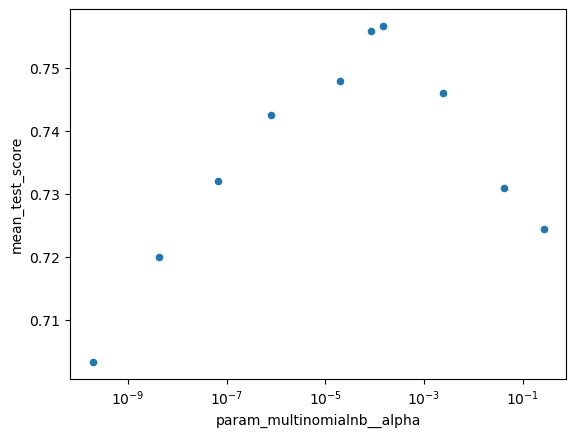

In [40]:
mnb_cv_results = pd.DataFrame(search_mnb.cv_results_)
mnb_cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

In [41]:
mnb_cv_results.iloc[:, [4, 11]]

,param_multinomialnb__alpha,mean_test_score
0,0.00002,0.747837
1,0.002407,0.745964
2,0.0,0.703324
3,0.041102,0.730963
4,0.000001,0.742443
5,0.0,0.720076
6,0.000148,0.756604
7,0.0,0.732001
8,0.268386,0.724452
9,0.000084,0.755851


In [42]:
search_mnb = RandomizedSearchCV(
    mnb,
    {
        "multinomialnb__alpha": loguniform(1e-7, 1e-2),
    },
    n_iter=10,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
)
search_mnb.fit(df["tokens"], df["fx"])
search_mnb.best_params_, search_mnb.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


({'multinomialnb__alpha': 3.254706297040939e-05}, 0.7522172287520315)

<Axes: xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

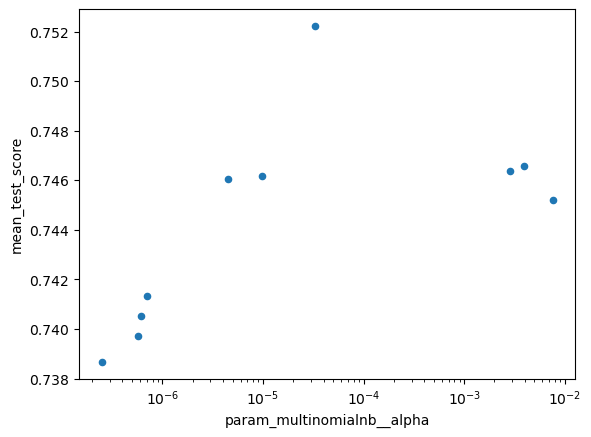

In [45]:
mnb_cv_results = pd.DataFrame(search_mnb.cv_results_)
mnb_cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

In [48]:
search_mnb = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "multinomialnb__alpha": loguniform(1e-6, 1e-3),
    },
    n_iter=20,
    scoring="f1",
    n_jobs=-1,
)
search_mnb.fit(df["tokens"], df["fx"])
search_mnb.best_params_, search_mnb.best_score_

({'countvectorizer__min_df': 9,
  'multinomialnb__alpha': 0.00037839498617390284},
 0.7524855187849335)

In [49]:
mnb_cv_results = pd.concat([mnb_cv_results, pd.DataFrame(search_mnb.cv_results_)])
mnb_cv_results["param_countvectorizer__min_df"] = mnb_cv_results[
    "param_countvectorizer__min_df"
].fillna(1)

<Axes: xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

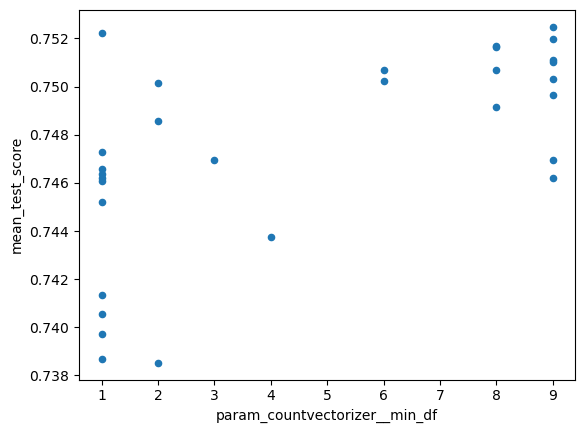

In [50]:
mnb_cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

<Axes: xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

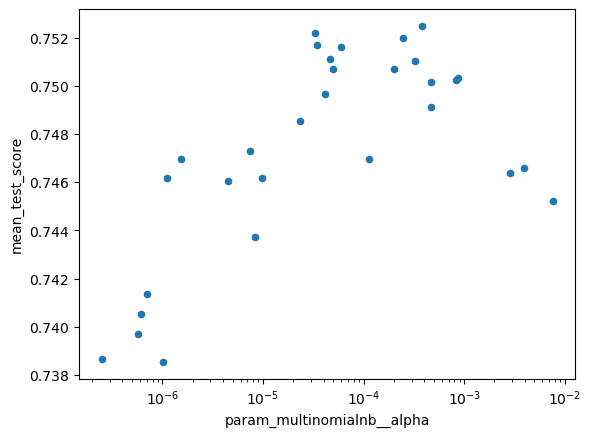

In [51]:
mnb_cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

<Axes: xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

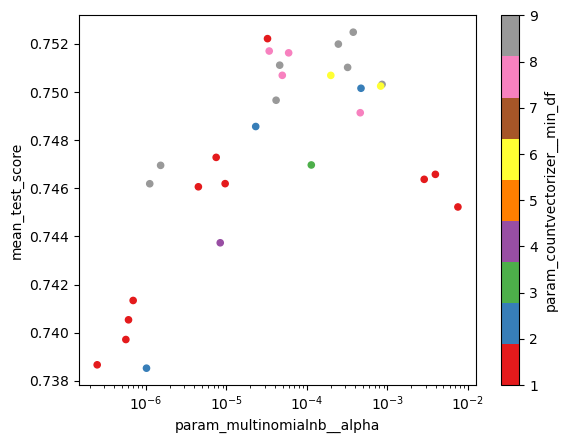

In [52]:
mnb_cv_results.plot(
    "param_multinomialnb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

In [53]:
search_mnb = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": [1, 2, 6, 8, 9],
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-6, 1e-3),
    },
    n_iter=10,
    n_jobs=-1,
    scoring="f1",
)
search_mnb.fit(df["tokens"], df["fx"])
search_mnb.best_params_, search_mnb.best_score_

({'countvectorizer__max_df': 0.7002915535129209,
  'countvectorizer__min_df': 9,
  'multinomialnb__alpha': 7.285367806577601e-05},
 0.7528963478600794)

In [55]:
mnb_cv_results = pd.concat([mnb_cv_results, pd.DataFrame(search_mnb.cv_results_)])
mnb_cv_results["param_countvectorizer__max_df"] = mnb_cv_results[
    "param_countvectorizer__max_df"
].fillna(1.0)

<Axes: xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

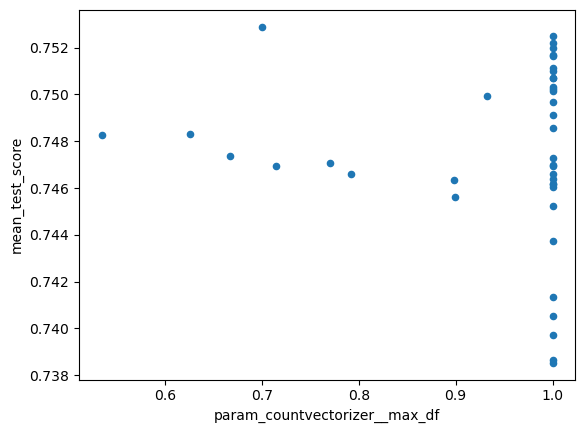

In [56]:
mnb_cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

<Axes: xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

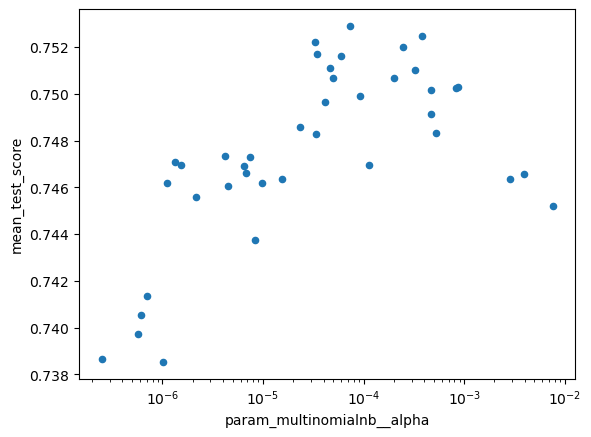

In [57]:
mnb_cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

**Observations:** min_df tuning resulted the best value to be 9. Words present in minimum of nine document will be considered. Where as max_df is best at 0.7. Words present in more than 70 percent of documents were ignored. Smoothing parameter alpha has been good at 1e-4.

In [58]:
mnb.set_params(
    multinomialnb__alpha=1e-4, countvectorizer__min_df=9, countvectorizer__max_df=0.7
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2b189b58fe00>,
                                 max_df=0.7, min_df=9)),
                ('multinomialnb', MultinomialNB(alpha=0.0001))])

In [61]:
mnb.set_params(**search_mnb.best_params_)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2b189b58fe00>,
                                 max_df=0.7002915535129209, min_df=9)),
                ('multinomialnb', MultinomialNB(alpha=7.285367806577601e-05))])

In [62]:
mnb_predicted = cross_val_predict(mnb, df["tokens"], df["fx"], cv=cv, n_jobs=-1)
print(classification_report(df["fx"], mnb_predicted))

              precision    recall  f1-score   support

       False       1.00      0.96      0.98     10071
        True       0.64      0.94      0.76       717

    accuracy                           0.96     10788
   macro avg       0.82      0.95      0.87     10788
weighted avg       0.97      0.96      0.96     10788



In [63]:
mnb_cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multinomialnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_countvectorizer__min_df,param_countvectorizer__max_df
0,0.425791,0.011268,0.093225,0.006352,0.000001,{'multinomialnb__alpha': 5.649415017965071e-07},0.699387,0.760383,0.689655,0.770270,0.778878,0.739715,0.037488,9,1,1.0
1,0.439965,0.018987,0.097126,0.005258,0.0,{'multinomialnb__alpha': 2.4865429593492867e-07},0.697531,0.765273,0.685535,0.766102,0.778878,0.738664,0.038968,10,1,1.0
2,0.438815,0.008008,0.097385,0.006304,0.007569,{'multinomialnb__alpha': 0.007569117902820918},0.701031,0.772455,0.689474,0.772455,0.790698,0.745222,0.041502,6,1,1.0


In [64]:
len(mnb_cv_results)

40

**Observations**

There was no significant improvement after tuning a multinomial nb model as the model was already better than the bernoulli nb model in the first place.

The optimized  bernoulli model is still underperforming than the default multinomial nb model.